# Let's consider some data for a fluorescence assay prepared with a Tecan HP D300 digital dispenser.

A summary of the experimental procedure:

>>
Two protein assay plates were prepared with p38 and Src plus  Bosutinib, using rows A-E and columns 1-12, varying protein concentration from row to row (high to low where E is just Buffer)  and Bosutinib concentration from column to column (high to low where 12 has no Bosutinib). 
Bosutinib concentrations started at 20 uM and went down by ½ log as calcuated by the D300 dispenser. Src concentrations were ~1, 0.5, 0.25, and 0.125 uM.  p38 concentrations were 10, 5, 2.5, 1.25 uM.

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

In [3]:
import re
import numpy as np

## Load fluorescence emission scans

In [4]:
# Load data
filename = 'data/12022014-019-src-280scan-reboot-bottom.txt' # data filename
from assaytools import platereader
[SRC_280, SRC_280_x, SRC_280_x_num] = platereader.read_emission_spectra_text(filename)

Couldn't import dot_parser, loading of dot files will not be possible.


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [5]:
## Plot the emission spectrum for 280 nm excitation

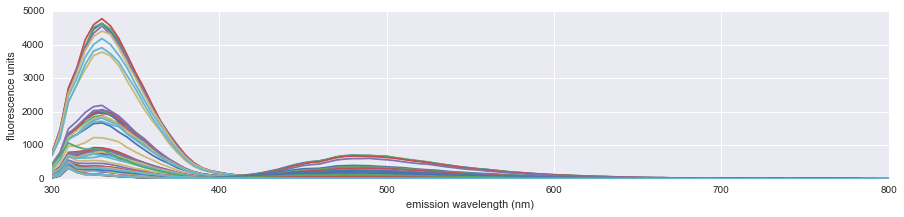

In [6]:
from assaytools import plots
plots.plot_scans(SRC_280, SRC_280_x, SRC_280_x_num)

## Find desired emission wavelength to fit.

In [7]:
# Find desired emission wavelength to fit.
wavelength_to_fit = '480'
index = SRC_280_x_num.index(wavelength_to_fit)

# Specify row to process
row_index = 0 # row 0, 1, 2, or 3
Pstated_rows = np.array([1, 0.5, 0.25, 0.125]) * 1e-6 # protein concentrations, M

# Extract fluorescence intensities at desired wavelength.
bottom_complex_fluorescence = np.array([ float(SRC_280[i,index]) for i in range(row_index*12+1,row_index*12+13) ])
bottom_ligand_fluorescence = np.array([ float(SRC_280[i,index]) for i in range(49,61) ])

# Stated concentrations of protein and ligand.
Pstated = Pstated_rows[row_index] * np.ones([12],np.float64) # protein concentration, M
Lstated = 20.0e-6 / np.array([10**(float(i)/2.0) for i in range(12)])

In [8]:
# Assay configuration details
assay_volume = 75e-6 # well volume, L
well_area = 0.1586 # well area, cm^2 # half-area wells were used here
path_length = assay_volume / well_area

# Uncertainties in protein and ligand concentrations.
dPstated = 0.10 * Pstated # protein concentration uncertainty
dLstated = 0.08 * Lstated # ligand concentraiton uncertainty (due to gravimetric preparation and HP D300 dispensing)

## Create pymc model

In [9]:
# Create the pymc model
from assaytools import pymcmodels
pymc_model = pymcmodels.make_model(Pstated, dPstated, Lstated, dLstated,
               bottom_complex_fluorescence=bottom_complex_fluorescence,
               bottom_ligand_fluorescence=bottom_ligand_fluorescence,
               use_primary_inner_filter_correction=True, 
               assay_volume=assay_volume, well_area=well_area)

## Plot fluorescence measurements of complex and ligand as a function of ligand concentration

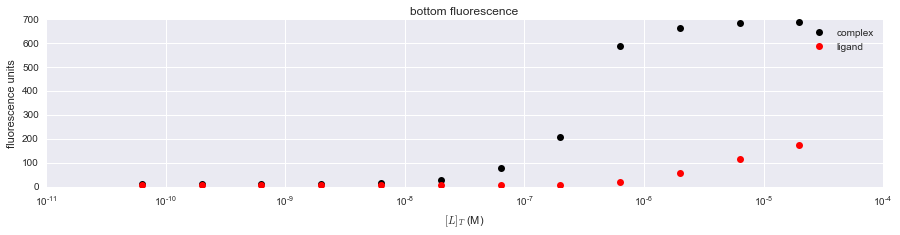

In [10]:
figure = plots.plot_measurements(Lstated, Pstated, pymc_model)

In [11]:
# Find the maximum a posteriori fit (will only be local optimum, and several cycles are needed for reasonable fit)
map = pymcmodels.map_fit(pymc_model)

MAP fitting cycle 5/5


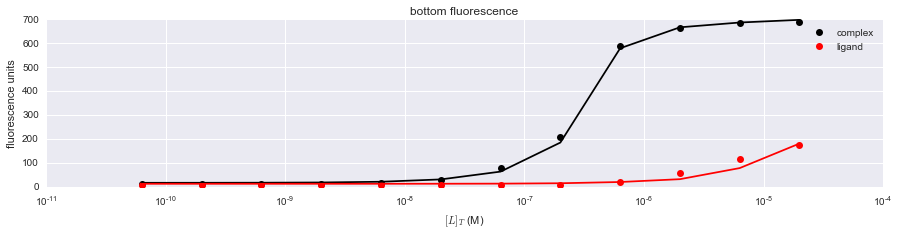

In [12]:
figure = plots.plot_measurements(Lstated, Pstated, pymc_model, map=map)

In [13]:
# Sample the model posterior with MCMC
mcmc = pymcmodels.run_mcmc(pymc_model)

(10000,)


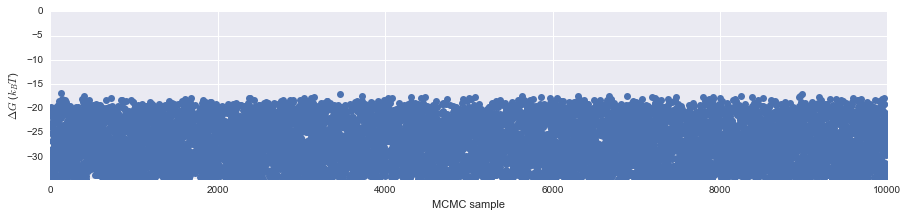

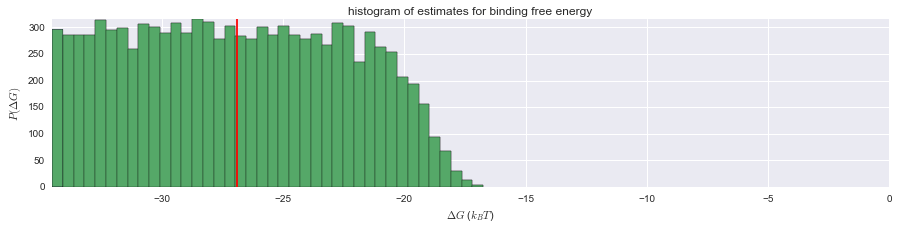

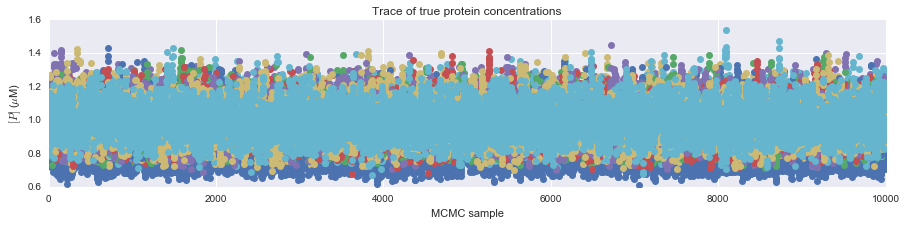

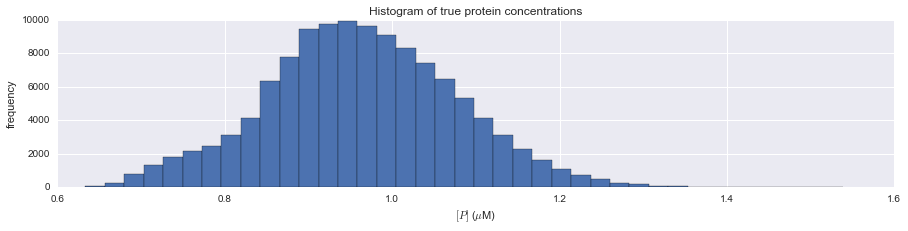

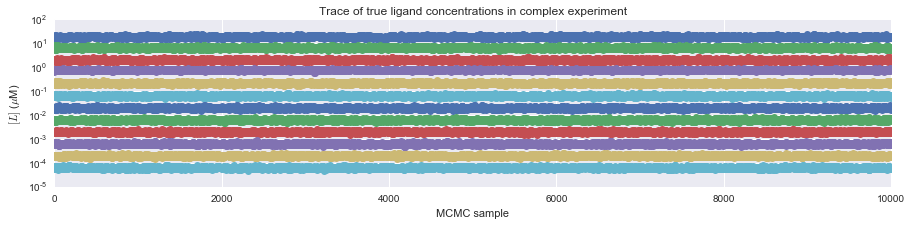

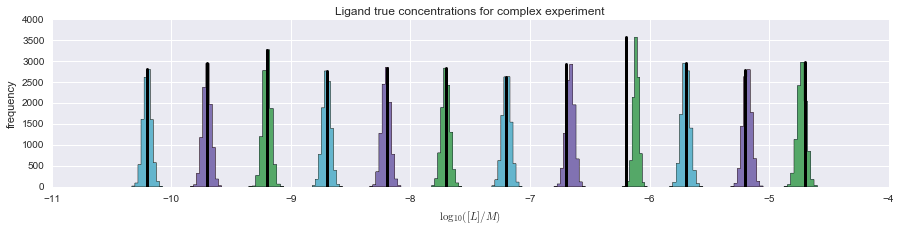

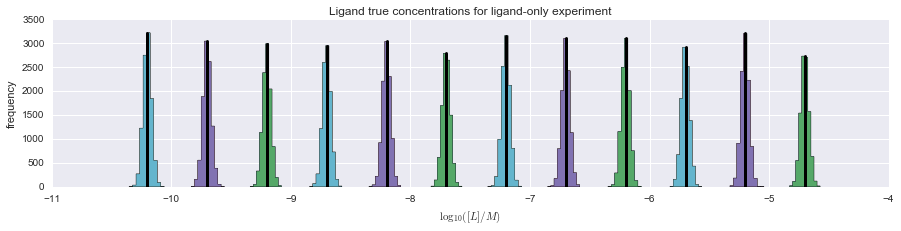

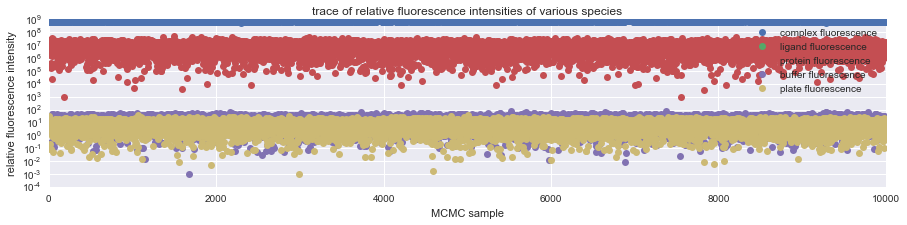

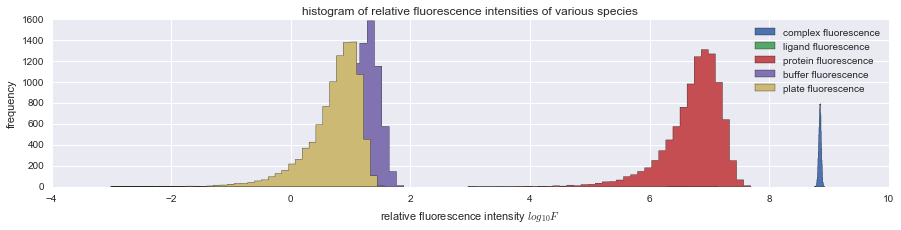

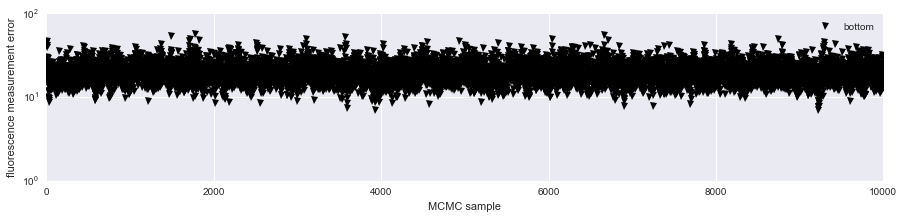

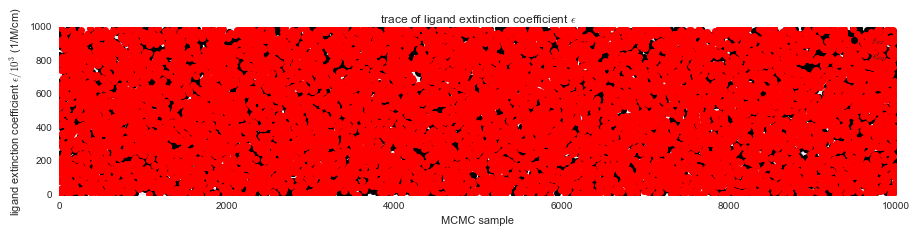

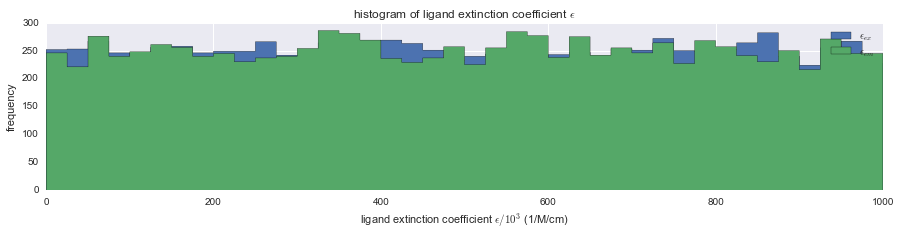

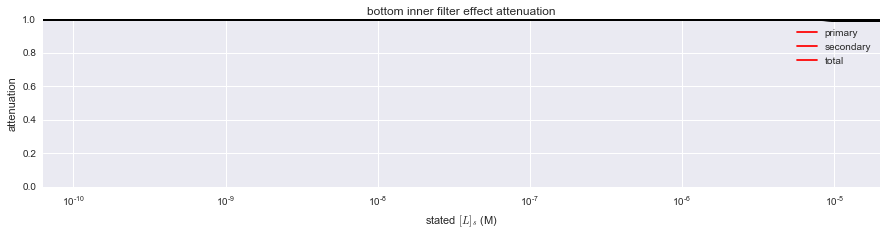

In [14]:
plots.plot_mcmc_results(Lstated, Pstated, path_length, mcmc)

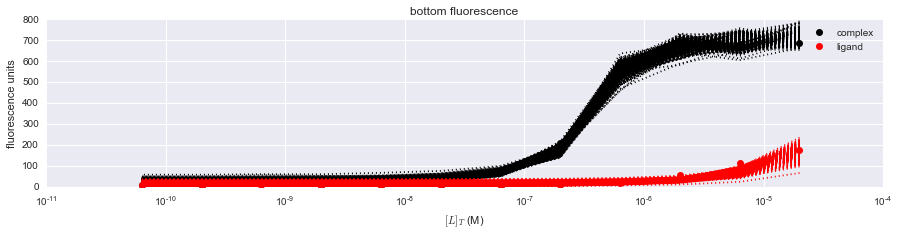

In [15]:
figure = plots.plot_measurements(Lstated, Pstated, pymc_model, mcmc=mcmc)

In [16]:
# Fit maximum a posteriori estimate one more time
map = pymcmodels.map_fit(pymc_model)

MAP fitting cycle 5/5


In [17]:
pymcmodels.show_summary(pymc_model, map, mcmc)

DeltaG = -34.5 +- 4.5 kT
Kd = 1.0 nM +- 2010371.8 fM

